# Задача: отследить аномальные всплески или спады подачи заявлений.

Все данные скрыты. Демонстрация с визуализацией по одной услуге

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sbn
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.metrics import r2_score, median_absolute_error, mean_absolute_error
from sklearn.metrics import median_absolute_error, mean_squared_error, mean_squared_log_error

In [2]:
df = pd.read_excel('Обработка_выгрузки_для_временных_рядов.xlsx',dtype='str')

df[['Активные_ЕНО', 'Просрочено_ЕНО',
           'План_по_ЕНО', 'weekday', 'quarter', 'Подано_ЕНО']] = df[['Активные_ЕНО', 'Просрочено_ЕНО',
           'План_по_ЕНО', 'weekday', 'quarter', 'Подано_ЕНО']].astype('int')

df['date'] = pd.to_datetime(df.date, format="%Y.%m.%d %H:%M:%S", errors = 'ignore')

df['year']=df.date.apply(lambda x: str(x)[:4])
df['month'] = df.date.apply(lambda x: str(x)[5:7])

df.index = df.date

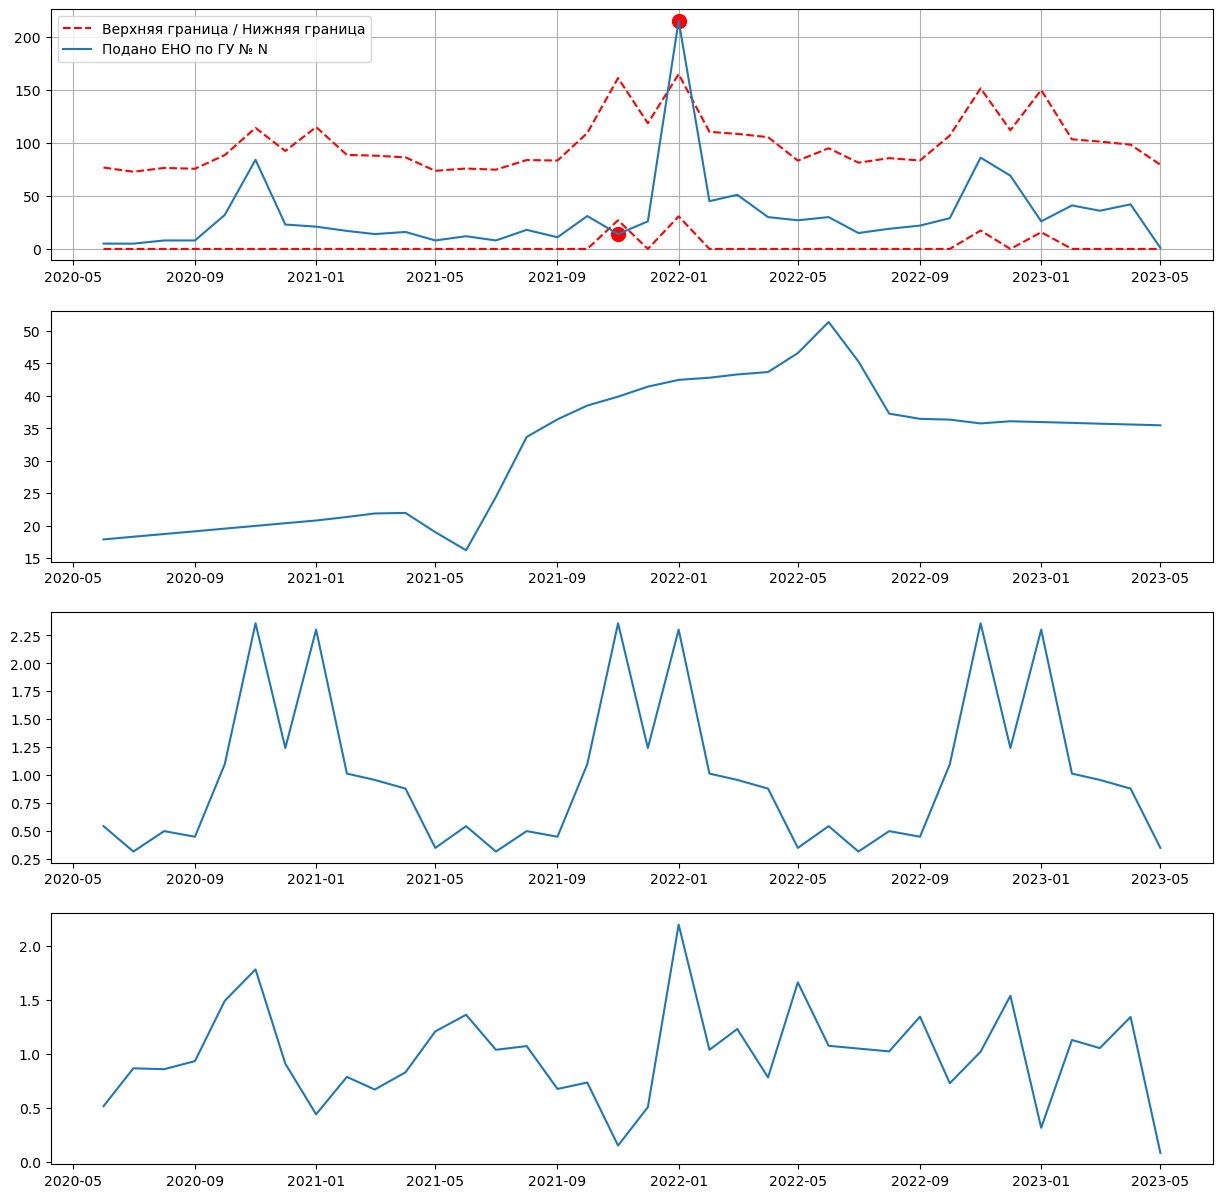

In [3]:
def plotMovingAverage(series, window, plot_intervals=False, scale=1.3, plot_anomalies=False):

    #rolling_mean = series.rolling(window=window).mean()

    fig, ax = plt.subplots(4, 1, figsize=(15, 15))
    #plt.title("Скользящая средняя\n Размер окна = {}".format(window))
    #plt.plot(rolling_mean, "g", label="Скользящий средний тренд")
    
    series_1 = series
    # декомпозиция временного ряда
    series.loc[series[series == 0].index] = 1
    
    ts_dicomposition = seasonal_decompose(series, model='multiplicative', extrapolate_trend=1)
    trend_estimate = ts_dicomposition.trend
    seasonal_estimate = ts_dicomposition.seasonal
    residual_estimate = ts_dicomposition.resid
    
    if sum(abs(residual_estimate[seasonal_estimate == seasonal_estimate.max()]) < 0.1):
        ts_dicomposition = seasonal_decompose(series, model='multiplicative', extrapolate_trend=1, period = 6)
        trend_estimate = ts_dicomposition.trend
        seasonal_estimate = ts_dicomposition.seasonal
        residual_estimate = ts_dicomposition.resid
        print(i)
    
    rolling_mean = series.rolling(window=window).mean()

    # границы
    if plot_intervals:
        mae = mean_absolute_error(series[window:], rolling_mean[window:])
        deviation = np.std(series[window:] - rolling_mean[window:])
        lower_bond = (abs(residual_estimate)/residual_estimate) * seasonal_estimate * trend_estimate - (mae + scale * deviation) - 5
        lower_bond.loc[lower_bond[lower_bond < 0].index] = 0
        upper_bond = (abs(residual_estimate)/residual_estimate) * seasonal_estimate * trend_estimate + (mae + scale * deviation) + 5
        upper_bond.loc[upper_bond[upper_bond < 0].index] = 0
        ax[0].plot(upper_bond, "r--", label="Верхняя граница / Нижняя граница")
        ax[0].plot(lower_bond, "r--")
        
        # аномалии выходящие за границы
        if plot_anomalies:
            anomalies = pd.DataFrame(index=series.index, data=series)[series.name]
            anomalies = anomalies[(series<lower_bond) | (series>upper_bond)]
            ax[0].plot(anomalies, "ro", markersize=10)
        
    
    ax[0].plot(series_1, label=f"Подано ЕНО по ГУ № N")
    ax[0].legend(loc="upper left")
    ax[0].grid(True)
    
    ax[1].plot(trend_estimate, label="Тренд")
    ax[2].plot(seasonal_estimate, label="Сезон")
    ax[3].plot(residual_estimate, label="Шум")
    
i = #####
    
df_service_kod = df[df.service_kod == i][-365*3:]

# создаем временные индексы
df_service_kod = df_service_kod.groupby(['year','month']).sum(numeric_only=True)
df_service_kod = df_service_kod.reset_index()
df_service_kod.index = df_service_kod.year + '-' + df_service_kod.month
df_service_kod.index = pd.to_datetime(df_service_kod.index, format="%Y-%m", errors = 'ignore')

if len(df_service_kod) >= 24:
    df_service_kod=df_service_kod[-36:]
    plotMovingAverage(df_service_kod.Подано_ЕНО, 4, plot_intervals=True, plot_anomalies=True)